In [1]:
import os
import time
import math
import requests
import bs4 as bs
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
import tensorflow as tf
from sklearn import metrics
from matplotlib import style
import yahoo_finance as yahoo
import googlefinance as google
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
from IPython.display import display, Math, Latex
style.use('ggplot')

C:\Users\Khanh\Anaconda3\envs\py35\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
def get_index_yahoo(ticker_name):
    getter = yahoo.Share(ticker_name)
    index = getter.get_historical('2000-1-1', '2016-12-31')
    date = np.array([index[i]['Date'] for i in range(len(index))])
    date = np.flip(date, axis=0)
    close = np.array([index[i]['Close'] for i in range(len(index))])
    close = np.flip(close, axis=0)
    close = close.astype(float)
    date = pd.to_datetime(date)
    return close, date

ndx_close, ndx_date = get_index_yahoo('^NDX')
# sp100_close, sp100_date = get_index_yahoo('^SP100') # cannot download
sp500_close, sp500_date = get_index_yahoo('^GSPC')
# dow_retail_close, dow_retail_date = get_index_yahoo('^DJUSRT') # cannot download

In [10]:
amzn = pd.read_csv('./amazon/amazon.csv')
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.set_index('Date', inplace=True)
amzn = amzn.loc['2000-01-01':'2016-12-31']
amzn.set_index(pd.to_datetime(ndx_date), inplace=True)
amzn['NDX'] = pd.Series(ndx_close, index=amzn.index)
amzn['SP500'] = pd.Series(sp500_close, index=amzn.index)
amzn.head()

,Open,High,Low,Close,Volume,Adj Close,NDX,SP500
2000-01-03,81.5000,89.5625,79.046799,89.3750,16117600,89.3750,3790.550049,1455.219971
2000-01-04,85.3750,91.5000,81.750000,81.9375,17487400,81.9375,3546.199951,1399.420044
2000-01-05,70.5000,75.1250,68.000000,69.7500,38457400,69.7500,3507.310059,1402.109985
2000-01-06,71.3125,72.6875,64.000000,65.5625,18752000,65.5625,3340.810059,1403.449951
2000-01-07,67.0000,70.5000,66.187500,69.5625,10505400,69.5625,3529.600098,1441.469971


In [11]:
def calculate_technical_indicator(data):
    data['ewma_5'] = data['Close'].ewm(span=5).mean()
    data['ewma_22'] = data['Close'].ewm(span=22).mean()
    data['ewma_200'] = data['Close'].ewm(span=200).mean()
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    data['Lower band'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()
    data['Upper band'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
    data['Middle band'] = data['Close'].rolling(window=20).mean()
    data['AO'] = ((data['High'] + data['Low'])/2).rolling(window=5).mean() - ((data['High'] + data['Low'])/2).rolling(window=34).mean()
    data['AC'] =  data['AO'] - data['AO'].rolling(window=5).mean()
    data['%R'] = (data['High'].max() - data['Close'])*100/(data['High'].max()-data['Low'].min())
    return data
   
amzn = calculate_technical_indicator(amzn)
amzn.head()

,Open,High,Low,Close,Volume,Adj Close,NDX,SP500,ewma_5,ewma_22,ewma_200,MACD,Lower band,Upper band,Middle band,AO,AC,%R
2000-01-03,81.5000,89.5625,79.046799,89.3750,16117600,89.3750,3790.550049,1455.219971,89.375000,89.375000,89.375000,0.000000,NaN,NaN,NaN,NaN,NaN,90.036236
2000-01-04,85.3750,91.5000,81.750000,81.9375,17487400,81.9375,3546.199951,1399.420044,84.912500,85.487216,85.637656,-0.166867,NaN,NaN,NaN,NaN,NaN,90.919865
2000-01-05,70.5000,75.1250,68.000000,69.7500,38457400,69.7500,3507.310059,1402.109985,77.730263,79.757700,80.288724,-0.590555,NaN,NaN,NaN,NaN,NaN,92.367827
2000-01-06,71.3125,72.6875,64.000000,65.5625,18752000,65.5625,3340.810059,1403.449951,72.675962,75.711003,76.551762,-0.919972,NaN,NaN,NaN,NaN,NaN,92.865332
2000-01-07,67.0000,70.5000,66.187500,69.5625,10505400,69.5625,3529.600098,1441.469971,71.480746,74.248056,75.125813,-0.920435,NaN,NaN,NaN,NaN,NaN,92.390104


In [12]:
amzn.to_csv('./amazon/full_amazon.csv')

In [2]:
amzn = pd.read_csv('./amazon/full_amazon.csv')
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.set_index('Date', inplace=True)
amzn

,Open,High,Low,Close,Volume,Adj Close,NDX,SP500,ewma_5,ewma_22,ewma_200,MACD,Lower band,Upper band,Middle band,AO,AC,%R
Date,,,,,,,,,,,,,,,,,,
2000-03-01,81.500000,89.562500,79.046799,89.375000,16117600,89.375000,3790.550049,1455.219971,89.375000,89.375000,89.375000,0.000000,NaN,NaN,NaN,NaN,NaN,90.036236
2000-04-01,85.375000,91.500000,81.750000,81.937500,17487400,81.937500,3546.199951,1399.420044,84.912500,85.487216,85.637656,-0.166867,NaN,NaN,NaN,NaN,NaN,90.919865
2000-05-01,70.500000,75.125000,68.000000,69.750000,38457400,69.750000,3507.310059,1402.109985,77.730263,79.757700,80.288724,-0.590555,NaN,NaN,NaN,NaN,NaN,92.367827
2000-06-01,71.312500,72.687500,64.000000,65.562500,18752000,65.562500,3340.810059,1403.449951,72.675962,75.711003,76.551762,-0.919972,NaN,NaN,NaN,NaN,NaN,92.865332
2000-07-01,67.000000,70.500000,66.187500,69.562500,10505400,69.562500,3529.600098,1441.469971,71.480746,74.248056,75.125813,-0.920435,NaN,NaN,NaN,NaN,NaN,92.390104
2000-10-01,72.562500,72.625000,65.562500,69.187500,14757900,69.187500,3717.409912,1457.599976,70.642763,73.201915,74.111187,-0.919448,NaN,NaN,NaN,NaN,NaN,92.434656
2000-11-01,66.875000,70.000000,65.000000,66.750000,10532700,66.750000,3544.350098,1438.560059,69.264509,72.010803,73.027780,-1.013400,NaN,NaN,NaN,NaN,NaN,92.724249
2000-12-01,67.875000,68.000000,63.000000,63.562500,10804500,63.562500,3478.139893,1432.250000,67.286667,70.589893,71.802797,-1.211701,NaN,NaN,NaN,NaN,NaN,93.102947
2000-01-13,64.937500,67.187500,63.125000,65.937500,10448100,65.937500,3612.080078,1449.680054,66.824934,69.866200,71.124727,-1.212752,NaN,NaN,NaN,NaN,NaN,92.820780


In [3]:
temporal_windows = 15
def prepare_data_features(data, windows):
    l = []
    cols = data.columns
    for w in range(windows):
        shift = data.shift(periods=w+1, axis=0)
        shift.columns = [(cols[i] + '_{}'.format(w+1)) for i in range(len(cols))]
        l.append(shift)
    output = pd.concat(l, axis=1)
    output.dropna(axis=0, how='any', inplace=True)
    return output
horizons = 5
def prepare_data_target(data, horizons):
    cols = data.columns
    l = []
    for h in range(horizons):
        shift = data.shift(periods=-h, axis=0)
        shift.columns = [(cols[i] + '_{}'.format(h+1)) for i in range(len(cols))]
        l.append(shift)
    output = pd.concat(l, axis=1)
    output.dropna(axis=0, how='any', inplace=True)
    return output

amzn_train = prepare_data_features(amzn, temporal_windows)

amzn_y = prepare_data_target(amzn.loc[amzn_train.index][['Close']], horizons)
amzn_train.head()

,Open_1,High_1,Low_1,Close_1,Volume_1,Adj Close_1,NDX_1,SP500_1,ewma_5_1,ewma_22_1,...,ewma_5_15,ewma_22_15,ewma_200_15,MACD_15,Lower band_15,Upper band_15,Middle band_15,AO_15,AC_15,%R_15
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-17,62.2500,66.375,60.000,66.2500,9703100.0,66.2500,4353.330078,1458.469971,65.461490,66.738562,...,68.739891,70.635249,70.458645,-0.562306,59.199663,84.887837,72.043750,-2.706249,-1.203318,92.442082
2000-03-20,66.0625,66.375,64.500,64.8125,5298500.0,64.8125,4440.450195,1464.469971,65.245160,66.569719,...,67.743260,70.197855,70.313567,-0.849892,59.976720,84.517030,72.246875,-2.783454,-0.673713,92.843056
2000-03-21,63.5000,64.500,62.375,64.1875,5813500.0,64.1875,4261.149902,1456.630005,64.892607,66.361035,...,68.120507,70.079719,70.270150,-0.826510,60.616698,84.308302,72.462500,-2.206161,0.114776,92.471783
2000-03-22,65.1250,73.000,62.250,72.3750,17082900.0,72.3750,4449.330078,1493.869995,67.386738,66.887523,...,67.372005,69.705102,70.140129,-1.028638,60.379491,84.389259,72.384375,-2.477852,0.009391,92.828205
2000-03-23,70.8750,74.000,69.250,70.6875,11566400.0,70.6875,4596.810059,1500.640015,68.486992,67.219994,...,65.768836,69.070093,69.920277,-1.429706,59.308744,84.772506,72.040625,-3.403036,-0.687686,93.221754


In [4]:
amzn_y.head()

,Close_1,Close_2,Close_3,Close_4,Close_5
Date,,,,,
2000-03-17,64.8125,64.1875,72.3750,70.6875,67.6875
2000-03-20,64.1875,72.3750,70.6875,67.6875,72.6875
2000-03-21,72.3750,70.6875,67.6875,72.6875,73.1250
2000-03-22,70.6875,67.6875,72.6875,73.1250,70.1250
2000-03-23,67.6875,72.6875,73.1250,70.1250,66.2500


In [5]:
def inter_polation_norm(x):
    return (x-x.min())/(x.max() - x.min())
def z_score_norm(x):
    return (x - x.mean())/x.std()
amzn_x = inter_polation_norm(amzn_train.loc[amzn_y.index])
amzn_y = inter_polation_norm(amzn_y)
amzn_x.head()

,Open_1,High_1,Low_1,Close_1,Volume_1,Adj Close_1,NDX_1,SP500_1,ewma_5_1,ewma_22_1,...,ewma_5_15,ewma_22_15,ewma_200_15,MACD_15,Lower band_15,Upper band_15,Middle band_15,AO_15,AC_15,%R_15
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-17,0.067081,0.071661,0.065250,0.071900,0.084365,0.071900,0.855279,0.490186,0.071089,0.072992,...,0.075025,0.077784,0.081540,0.521105,0.067359,0.089111,0.079003,0.536583,0.477269,0.924671
2000-03-20,0.071620,0.071661,0.070639,0.070185,0.041745,0.070185,0.876276,0.493947,0.070829,0.072784,...,0.073829,0.077246,0.081336,0.516774,0.068324,0.088679,0.079250,0.536148,0.488488,0.928697
2000-03-21,0.068569,0.069432,0.068094,0.069440,0.046728,0.069440,0.833063,0.489033,0.070406,0.072528,...,0.074282,0.077100,0.081275,0.517126,0.069120,0.088437,0.079512,0.539406,0.505190,0.924969
2000-03-22,0.070504,0.079538,0.067945,0.079205,0.155775,0.079205,0.878416,0.512378,0.073401,0.073175,...,0.073383,0.076640,0.081092,0.514082,0.068825,0.088531,0.079417,0.537873,0.502958,0.928548
2000-03-23,0.077350,0.080727,0.076327,0.077193,0.102395,0.077193,0.913961,0.516622,0.074722,0.073584,...,0.071458,0.075859,0.080782,0.508043,0.067494,0.088976,0.078999,0.532650,0.488192,0.932499


In [6]:
amzn_y.tail()

,Close_1,Close_2,Close_3,Close_4,Close_5
Date,,,,,
2016-12-19,0.906535,0.912761,0.912022,0.906941,0.900082
2016-12-20,0.912761,0.912022,0.906941,0.900082,0.912976
2016-12-21,0.912022,0.906941,0.900082,0.912976,0.913847
2016-12-22,0.906941,0.900082,0.912976,0.913847,0.905521
2016-12-23,0.900082,0.912976,0.913847,0.905521,0.887296


In [7]:
## Train test split
amzn_x_train, amzn_y_train = amzn_x.loc[:'2014-01-01'].as_matrix(), amzn_y.loc[:'2014-01-01'].as_matrix()
amzn_x_test, amzn_y_test = amzn_x.loc['2014-01-01':].as_matrix(), amzn_y.loc['2014-01-01':].as_matrix()

In [8]:
## params
N_FEATURES = amzn_x_train.shape[1] # number of input features
PREDICTION_HORIZONS = 5
X = tf.placeholder(tf.float32, [None, N_FEATURES])
Y = tf.placeholder(tf.float32, [None, PREDICTION_HORIZONS])

In [9]:
def new_fc_layer(in_layer, n_input_features, n_output_layer, activation=''):
    weights = tf.Variable(tf.truncated_normal([n_input_features, n_output_layer], stddev=0.1))
    biases = tf.Variable(tf.constant(value=1, dtype=tf.float32, shape = [n_output_layer]))
    out_layer = tf.matmul(in_layer, weights) + biases
    activation = activation.lower()
    if(activation == 'relu'):
        out_layer = tf.nn.relu(out_layer)
    elif(activation == 'tanh'):
        out_layer = tf.nn.tanh(out_layer)
    elif(activation == 'sigmoid'):
        out_layer = tf.nn.sigmoid(out_layer)
    return out_layer, weights, biases
## Hidden layer 1
N_HIDDEN_L1 = N_FEATURES
hidden_layer_1, weight_1, biases_1 = new_fc_layer(X, N_FEATURES, N_HIDDEN_L1, 'relu')
## Hidden layer 2
N_HIDDEN_L2 = PREDICTION_HORIZONS
hidden_layer_2, weight_2, biases_2 = new_fc_layer(hidden_layer_1, N_HIDDEN_L1, N_HIDDEN_L2, 'sigmoid')

print (hidden_layer_1)
print (hidden_layer_2)

Tensor("Relu:0", shape=(?, 270), dtype=float32)
Tensor("Sigmoid:0", shape=(?, 5), dtype=float32)


In [13]:
def reshape_target_array(data, horizons):
    l = np.array(data[:,0])
    for i in range(data.shape[0]):
        l[i] = (np.mean([data[i-j, k] for j, k in zip(range(horizons), range(horizons)) if (i >= j)]))
    return l

In [10]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
cost = tf.reduce_mean(tf.square(hidden_layer_2-Y))
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           20000, 0.8, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)
y_pred = hidden_layer_2
y_true = Y

In [11]:
# ## Cost function and optimization
# # BETA = 0.001 #L2 regularization penalty factor
# LEARNING_RATE = 1e-4
# cost = tf.reduce_mean(tf.square(hidden_layer_2-Y)) # To be added L2 regularization
# optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)
# ## Making Prediction
# y_pred = hidden_layer_2
# y_true = Y

Training.......
-- Elapsed time -- Epoch -- Cost value -- 
--     0.078557 --     0 --    0.11598 -- 
-- Making prediction at 0th epoch
Making prediction.......
RMSE = 0.39486345795227135
MAE = 0.32680033944804776
---Running time: 0.06554555892944336 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--    91.367839 --  1000 --    0.00007 -- 
-- Making prediction at 1000th epoch
Making prediction.......
RMSE = 0.1475864993403701
MAE = 0.09793795649926608
---Running time: 0.20964741706848145 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--   183.767416 --  2000 --    0.00003 -- 
-- Making prediction at 2000th epoch
Making prediction.......
RMSE = 0.11344625052771583
MAE = 0.07782609287107772
---Running time: 0.08255839347839355 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--   276.020156 --  3000 --    0.00003 -- 

C:\Users\Khanh\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


-- Elapsed time -- Epoch -- Cost value -- 
--  2800.351886 -- 21000 --    0.00002 -- 
-- Making prediction at 21000th epoch
Making prediction.......
RMSE = 0.052905237302076955
MAE = 0.03836843685002614
---Running time: 0.07105088233947754 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--  2992.744514 -- 22000 --    0.00002 -- 
-- Making prediction at 22000th epoch
Making prediction.......
RMSE = 0.05291063238171952
MAE = 0.03836903534433309
---Running time: 0.069549560546875 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--  3191.010750 -- 23000 --    0.00002 -- 
-- Making prediction at 23000th epoch
Making prediction.......
RMSE = 0.052915373264435225
MAE = 0.03837204718407482
---Running time: 0.06904864311218262 seconds ---
**************************************************
-- Elapsed time -- Epoch -- Cost value -- 
--  3394.227978 -- 24000 --    0.00002 -- 
-- Makin

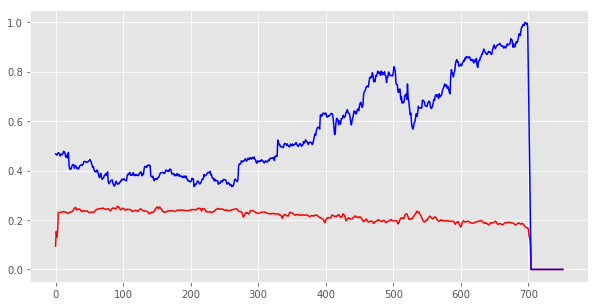

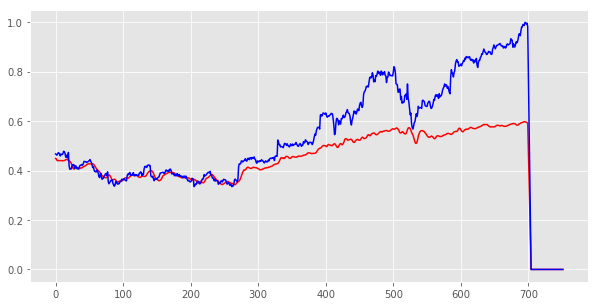

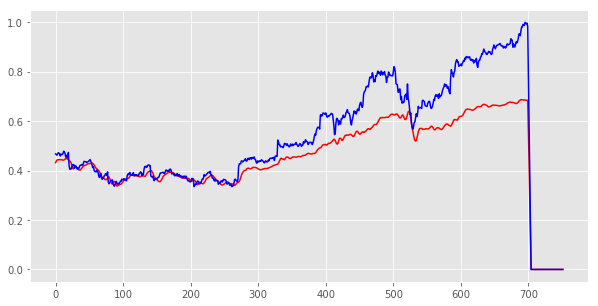

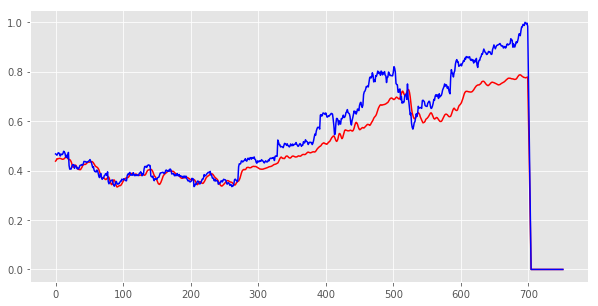

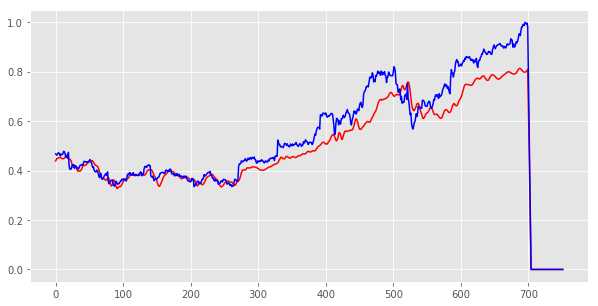

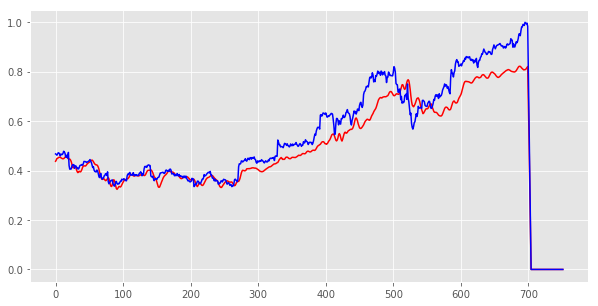

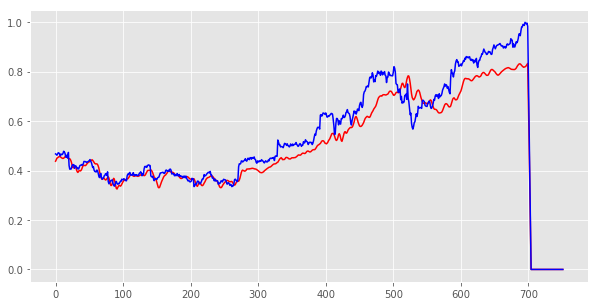

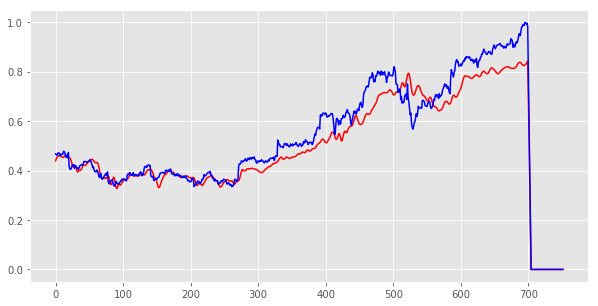

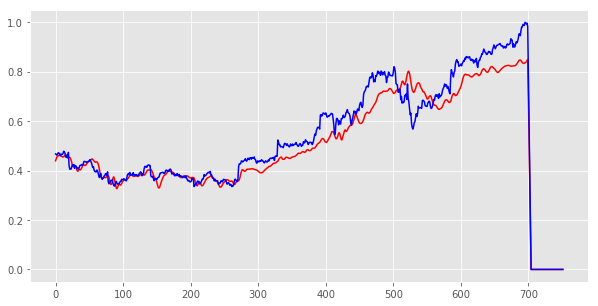

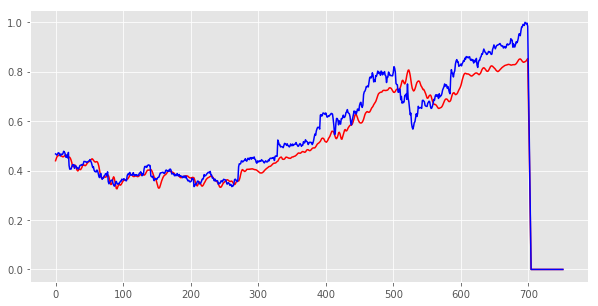

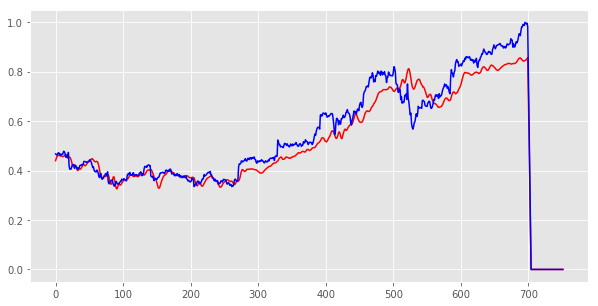

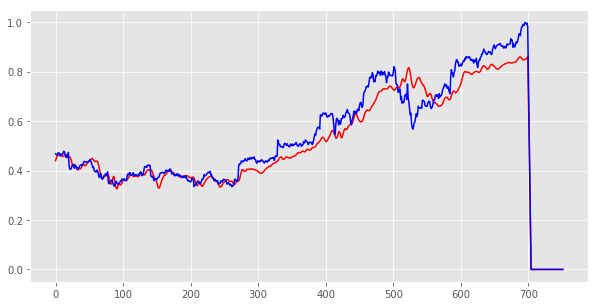

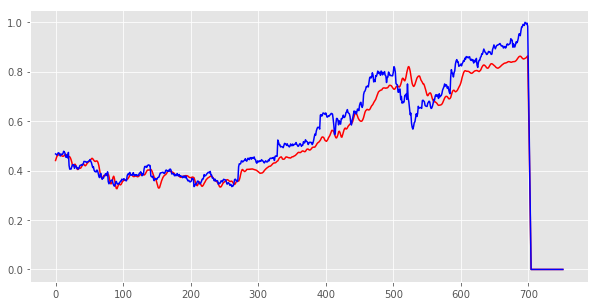

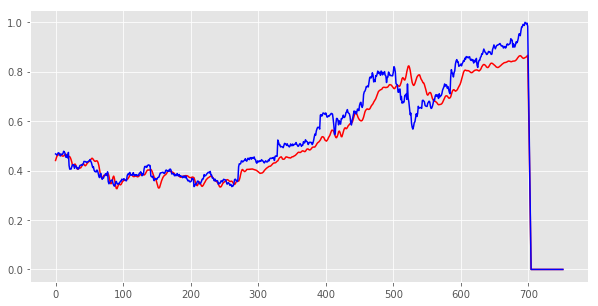

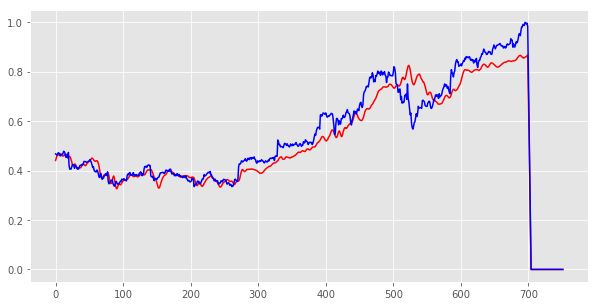

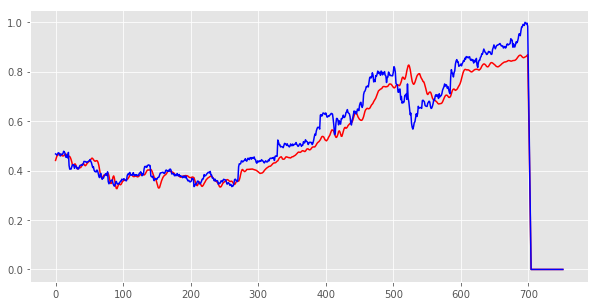

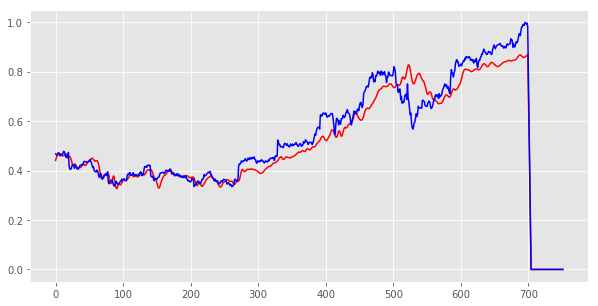

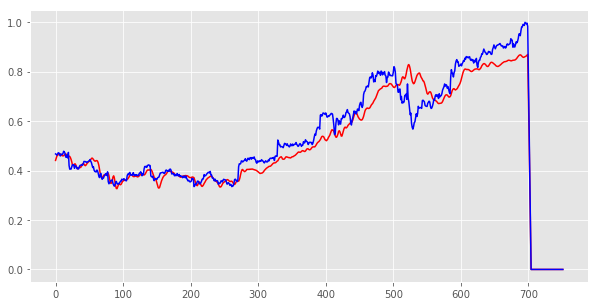

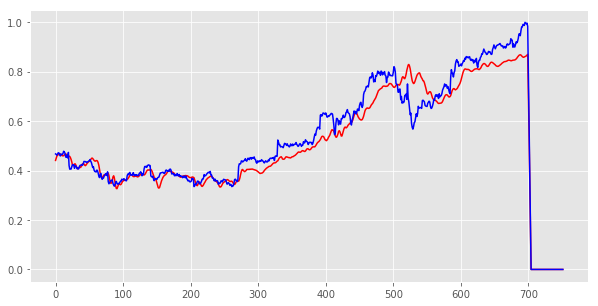

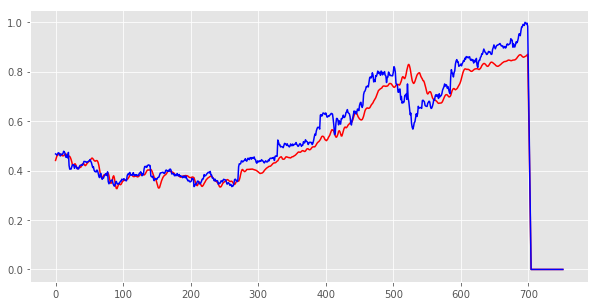

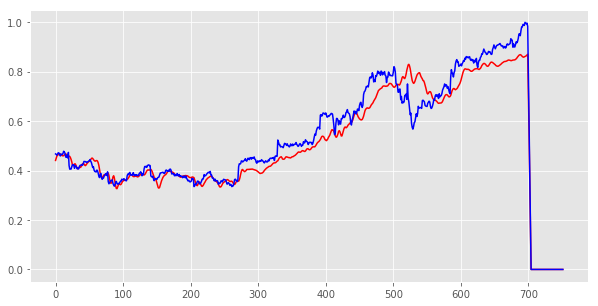

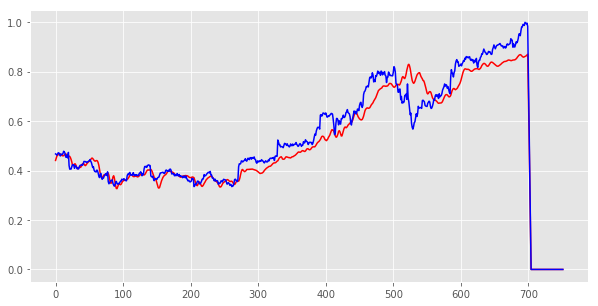

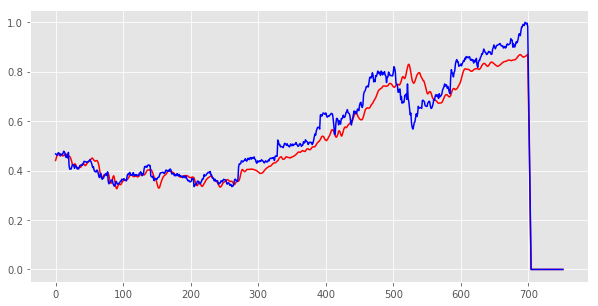

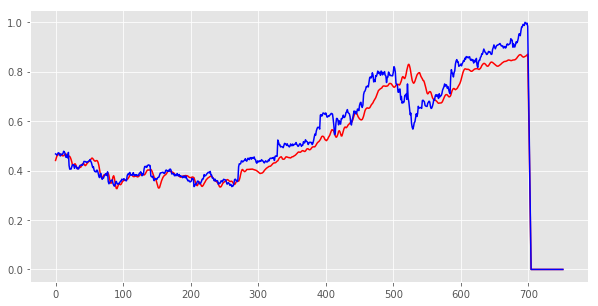

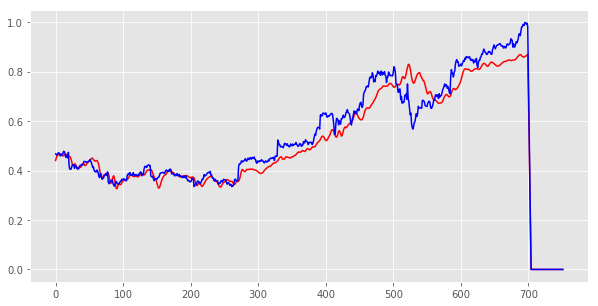

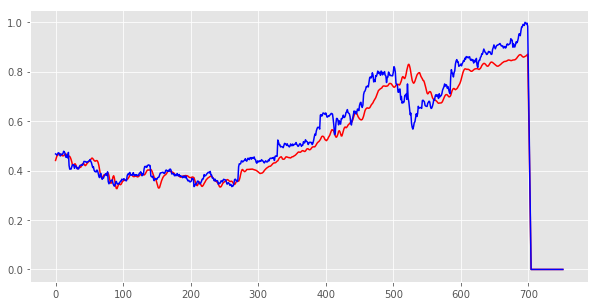

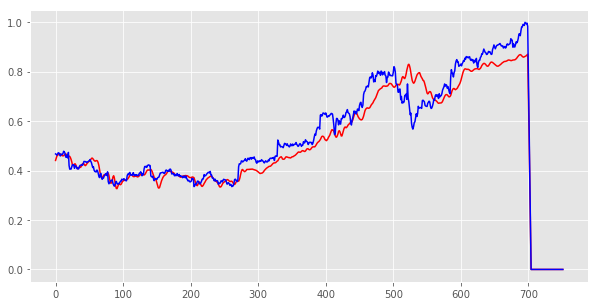

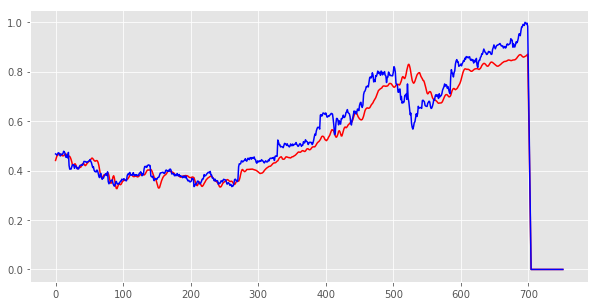

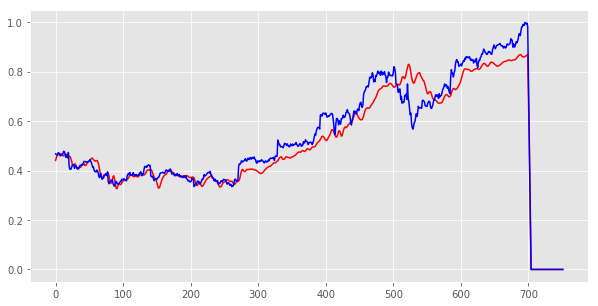

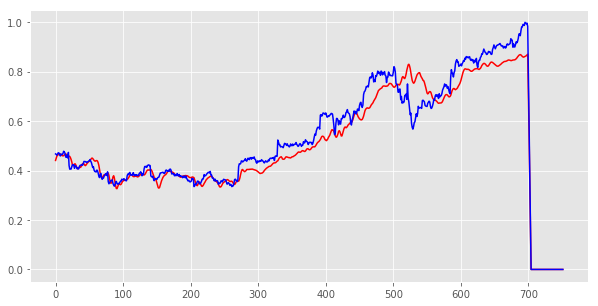

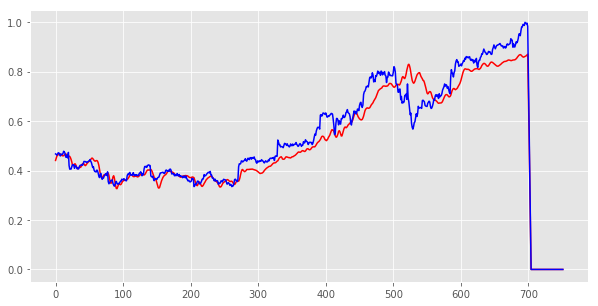

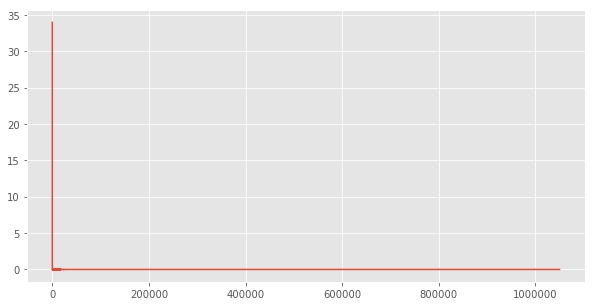

Making prediction on training set
Making prediction.......
RMSE = 0.003663239467673783
MAE = 0.00252827181733988
---Running time: 0.16861963272094727 seconds ---
**************************************************
Making training prediction on test 1 set
Making prediction.......
RMSE = 0.052917373191829285
MAE = 0.03837173946056489
---Running time: 0.07004904747009277 seconds ---
**************************************************


In [14]:
BATCH_SIZE = 100
TRAINING_EPOCHS = 30000

## Helper function for optimization
def optimize(train_x, train_y, n_epochs, batch_size, session, saver):
    n_samples = train_x.shape[0]
    n_iterations = np.int(np.floor(n_samples/batch_size))+1
    start_time = time.time()
    cost_history = np.empty(shape=[1],dtype=float)
    print ("Training.......")
        
    dir_path = './amzn_test_2/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for epoch in np.arange(n_epochs+1):
        for itr in np.arange(n_iterations):
            start = (itr * batch_size) % (n_samples - batch_size)
            batch_x, batch_y = train_x[start:start + batch_size], train_y[start:start + batch_size]
            feed_dict_train = {X: batch_x, Y: batch_y}
            _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)
            cost_history = np.append(cost_history,c)
            
        if(epoch % 1000 == 0):
            print ("-- Elapsed time -- Epoch -- Cost value -- ")
            print ("-- {:12.6f} -- {:5d} -- {:10.5f} -- ".format((time.time() - start_time), 
                                                                                    epoch, 
                                                                                    c, 
                                                                                    ))
            print ("-- Making prediction at {}th epoch".format(epoch))
            make_prediction(amzn_x_test, amzn_y_test, sess, BATCH_SIZE)
            plt.savefig('{0}{1}th_epoch'.format(dir_path, epoch), dpi=1000)
        
#             Draw weights of convolutional layer
#             if(epoch % (n_epochs/2) == 0):
#                 plot_conv_weights(session, conv_weights[0], 'conv_1', 1, epoch)
#                 plot_conv_weights(session, conv_weights[1], 'conv_2', 1, epoch)
#                 plot_conv_weights(session, conv_weights[2], 'conv_3', 1, epoch)
                  
#         Save model in folder rnn_model
        
#         saver.save(sess, 'rnn_model/new_cnn')
        
#         print running time and output cost value graph
    print ("---Running time: %s seconds ---" % (time.time() - start_time))
    print ('*'*50)
    fig = plt.figure(figsize=(10,5))
    plt.clf()
    plt.plot(cost_history)
    plt.show()


## Helper function to print confusion matrix
def make_prediction(test_x, test_y, session, batch_size):
    print ("Making prediction.......")
    start_time = time.time()
    n_samples = test_x.shape[0]
    n_iterations = np.int(np.floor(n_samples/batch_size))+1
    pred = np.zeros((n_samples, test_y.shape[1]))
    true = np.zeros((n_samples, test_y.shape[1]))
    for itr in np.arange(n_iterations):
        start = (itr * batch_size) % (n_samples - batch_size)
        batch_x, batch_y = test_x[start:start + batch_size], test_y[start:start + batch_size]
        feed_dict_test = {X: batch_x, Y: batch_y}
        pred[start:start + batch_size], true[start:start + batch_size] = session.run([y_pred, y_true], feed_dict=feed_dict_test)
    pred = reshape_target_array(pred, horizons)
    true = reshape_target_array(true, horizons)
    rmse = math.sqrt(metrics.mean_squared_error(pred, true))
    mae = metrics.mean_absolute_error(pred, true)
    print ("RMSE = {}".format(rmse))
    print ("MAE = {}".format(mae))
    plt.clf()
    plt.close()
    fig = plt.figure(figsize=(10,5))
    
    plt.plot(range(n_samples), pred, color = 'r')
    plt.plot(range(n_samples), true, color = 'b')
#     plt.show()
    print ("---Running time: {0} seconds ---".format((time.time() - start_time)))
    print ('*'*50)

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    optimize(amzn_x_train, amzn_y_train, TRAINING_EPOCHS, BATCH_SIZE, sess, saver)
    print ("Making prediction on training set")
    make_prediction(amzn_x_train, amzn_y_train, sess, BATCH_SIZE)
    print ("Making training prediction on test 1 set")
    make_prediction(amzn_x_test, amzn_y_test, sess, BATCH_SIZE)